In [19]:
# Importamos las librerías necesarias para el procesamiento de datos, modelado y visualización
import pandas as pd               # Para manejar y analizar datos en forma de tablas (DataFrames)
import numpy as np                # Para trabajar con matrices y operaciones matemáticas
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Para codificar datos categóricos y normalizar datos numéricos
from sklearn.metrics import confusion_matrix, classification_report  # Para evaluar el rendimiento del modelo
import tensorflow as tf           # Biblioteca principal para el modelado de redes neuronales profundas
from tensorflow.keras import layers, models  # Para crear capas y modelos en TensorFlow
import matplotlib.pyplot as plt    # Para generar gráficos
import seaborn as sns              # Para gráficos estadísticos, útil para visualizar resultados

# 1. Cargar y preparar los datos
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTDx2deUjDJ6kbKMnSuLzMSsVnv5VbqSMHQlOba8xYFRlyX8zCJN1ehrQZS1a9MAMzIN_MVWVQmBmH-/pub?output=csv"
# Definimos la URL del conjunto de datos. Este enlace proporciona acceso a los datos en formato CSV en Google Sheets.
data = pd.read_csv(url)  # Cargamos los datos desde la URL y los guardamos en un DataFrame de pandas

# Ver las primeras filas para entender la estructura
data.head()  # Mostramos las primeras filas del DataFrame para observar la estructura y el contenido del conjunto de datos


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 6:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 7:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 8:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [20]:
# 2. Limpieza de datos

# Eliminar filas con valores nulos
data = data.dropna()  # Eliminamos cualquier fila que tenga valores nulos en cualquier columna

# Seleccionar características relevantes para el modelo
features = ['Source Port', 'Destination Port', 'Protocol', 'Packet Length',  # Las características (columnas) que vamos a usar para entrenar el modelo
            'Anomaly Scores', 'Severity Level']
target = 'Attack Type'  # La columna que representa el tipo de ataque, es la variable objetivo (target)

# Convertir variables categóricas
le = LabelEncoder()  # Creamos un codificador para convertir las variables categóricas a valores numéricos
data['Protocol'] = le.fit_transform(data['Protocol'])  # Convertimos la columna 'Protocol' a valores numéricos (código)
data['Severity Level'] = le.fit_transform(data['Severity Level'])  # Convertimos 'Severity Level' a valores numéricos
y = le.fit_transform(data[target])  # Convertimos la columna 'Attack Type' (objetivo) en valores numéricos

# Preparar características
X = data[features].values  # Extraemos las características seleccionadas (features) y las convertimos en un array numpy

# Normalizar los datos
scaler = StandardScaler()  # Creamos un objeto para normalizar las características (ajustar la escala de los datos)
X = scaler.fit_transform(X)  # Aplicamos la normalización a los datos de entrada


In [21]:
# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# 4. Definir el modelo de red neuronal
def create_model(input_shape, num_classes):
    # Crear un modelo secuencial (las capas se añaden de forma lineal)
    model = models.Sequential([

        # Capa de entrada
        # 'Dense' crea una capa completamente conectada (fully connected).
        # 128 es el número de neuronas, y 'relu' es la función de activación que introduce no linealidad.
        # 'input_shape' especifica la forma de los datos de entrada (número de características de X).
        layers.Dense(128, activation='relu', input_shape=input_shape),
        
        # Dropout de 0.3: apaga aleatoriamente el 30% de las neuronas de la capa de entrada durante el entrenamiento,
        # para evitar el sobreajuste.
        layers.Dropout(0.3),

        # Primera capa oculta
        # 64 neuronas y la activación ReLU
        layers.Dense(64, activation='relu'),
        
        # Dropout de 0.2: apaga aleatoriamente el 20% de las neuronas de esta capa oculta.
        layers.Dropout(0.2),

        # Segunda capa oculta
        # 32 neuronas y la activación ReLU
        layers.Dense(32, activation='relu'),
        
        # Dropout de 0.2: apaga aleatoriamente el 20% de las neuronas de esta capa oculta.
        layers.Dropout(0.2),

        # Capa de salida
        # El número de neuronas en esta capa es igual al número de clases a predecir (num_classes).
        # 'softmax' convierte las salidas en probabilidades que suman 1, útil para clasificación multiclase.
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Retornar el modelo creado
    return model


In [23]:
# 5. Compilar y entrenar el modelo
# Calcular el número de clases en el conjunto de etiquetas (y), 
# que corresponde al número de categorías distintas en 'y'.
num_classes = len(np.unique(y))

# Crear el modelo llamando a la función 'create_model', 
# pasando la forma de los datos de entrada y el número de clases.
model = create_model((X_train.shape[1],), num_classes)

# Compilar el modelo
# 'adam' es un optimizador popular que ajusta el aprendizaje de forma eficiente.
# 'sparse_categorical_crossentropy' es la función de pérdida usada para clasificación multiclase
# cuando las etiquetas son enteros (no codificados en one-hot).
# 'accuracy' es la métrica para evaluar la precisión del modelo durante el entrenamiento.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
# Se entrena el modelo usando los datos de entrenamiento (X_train, y_train)
# 'epochs=50': El modelo se entrenará durante 50 iteraciones completas sobre el conjunto de entrenamiento.
# 'batch_size=32': El tamaño del lote de datos con los que el modelo hará un ajuste en cada paso.
# 'validation_split=0.2': El 20% de los datos de entrenamiento se usará para la validación del modelo.
# 'verbose=1': Muestra el progreso del entrenamiento (en formato de barra de progreso).
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50


/home/matias/python/my_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3221 - loss: 1.1228 - val_accuracy: 0.3636 - val_loss: 1.0997
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3478 - loss: 1.0991 - val_accuracy: 0.3889 - val_loss: 1.0989
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3582 - loss: 1.0986 - val_accuracy: 0.3687 - val_loss: 1.1002
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3324 - loss: 1.0959 - val_accuracy: 0.3737 - val_loss: 1.1027
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3799 - loss: 1.0889 - val_accuracy: 0.3384 - val_loss: 1.1040
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3892 - loss: 1.0889 - val_accuracy: 0.3788 - val_loss: 1.1049
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4075 - loss: 1.0806 - val_accuracy: 0.3333 - val_loss: 1.1043
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4284 - loss: 1.0737 - val_accuracy: 0.3283 - val_loss: 1.1050
E

In [24]:
# 6. Evaluar el modelo
# Evaluación en conjunto de prueba
# Usamos el conjunto de prueba (X_test, y_test) para evaluar el rendimiento del modelo.
# 'evaluate' devuelve la pérdida y las métricas de evaluación especificadas en el proceso de compilación (en este caso, la precisión).
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Imprimimos la precisión obtenida en el conjunto de prueba
# 'test_accuracy' contiene el valor de precisión sobre los datos de prueba.
print(f'\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}')

# Generar predicciones
# Usamos el método 'predict' para generar las predicciones del modelo sobre el conjunto de prueba (X_test).
# 'y_pred' contiene las probabilidades predichas por el modelo para cada clase.
y_pred = model.predict(X_test)

# Convertir las probabilidades en clases predichas
# 'np.argmax' selecciona la clase con la mayor probabilidad para cada muestra.
# 'axis=1' indica que se debe aplicar sobre las filas (cada muestra) y no sobre las columnas.
# 'y_pred_classes' tendrá los índices de las clases predichas para cada muestra.
y_pred_classes = np.argmax(y_pred, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3720 - loss: 1.1357

Precisión en el conjunto de prueba: 0.3790
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


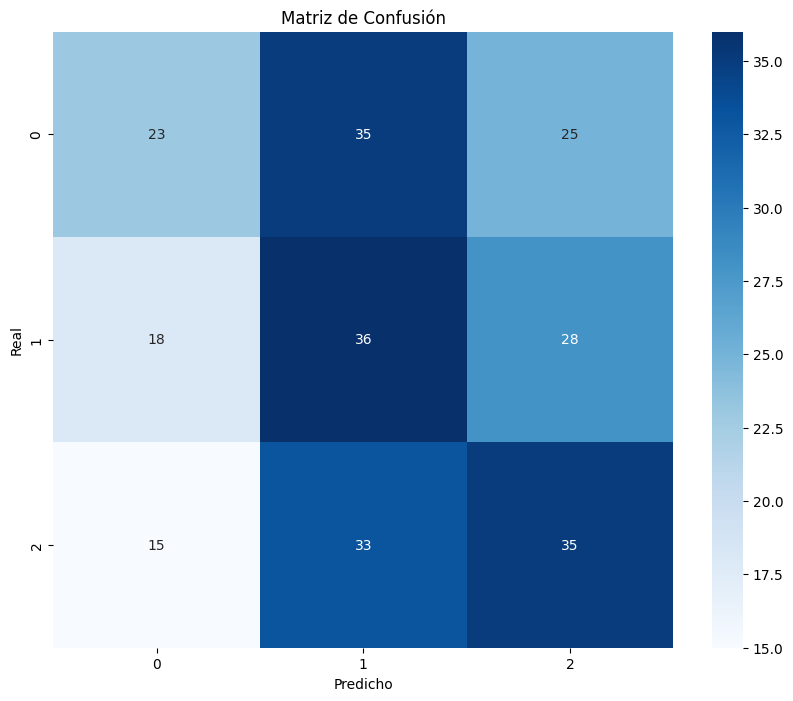

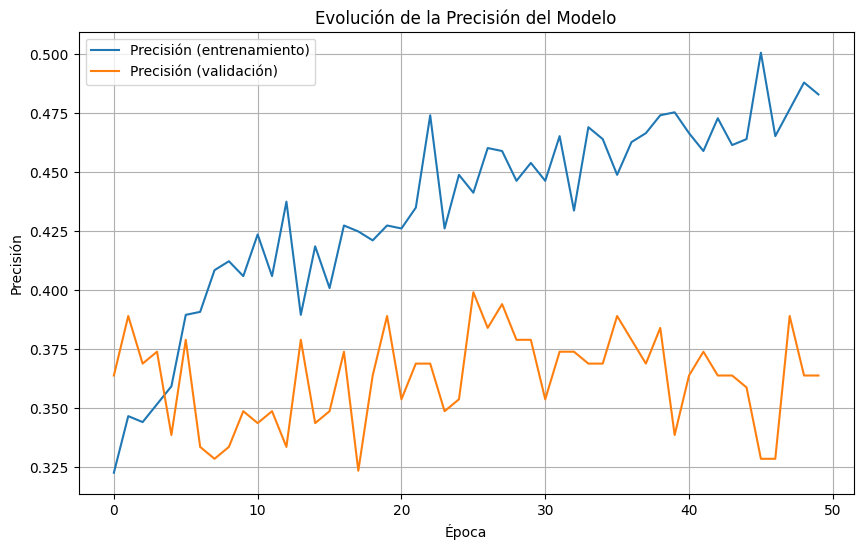


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.41      0.28      0.33        83
           1       0.35      0.44      0.39        82
           2       0.40      0.42      0.41        83

    accuracy                           0.38       248
   macro avg       0.38      0.38      0.38       248
weighted avg       0.39      0.38      0.38       248



In [25]:
# 7. Visualizar resultados
# Matriz de confusión
# Para evaluar el rendimiento del modelo de forma más detallada, generamos una matriz de confusión,
# que muestra cuántas veces el modelo predijo correctamente o incorrectamente cada clase.
plt.figure(figsize=(10, 8))  # Definir el tamaño de la figura para la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)  # Calculamos la matriz de confusión comparando las predicciones con los valores reales
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Usamos Seaborn para graficar la matriz con anotaciones
plt.title('Matriz de Confusión')  # Título de la gráfica
plt.xlabel('Predicho')  # Etiqueta para el eje X (clases predichas)
plt.ylabel('Real')  # Etiqueta para el eje Y (clases reales)
plt.show()  # Mostrar la gráfica

# Gráfico de la precisión durante el entrenamiento
# Este gráfico muestra cómo la precisión del modelo cambió a lo largo de las épocas durante el entrenamiento
plt.figure(figsize=(10, 6))  # Definir el tamaño de la figura para el gráfico de precisión
plt.plot(history.history['accuracy'], label='Precisión (entrenamiento)')  # Graficar precisión durante el entrenamiento
plt.plot(history.history['val_accuracy'], label='Precisión (validación)')  # Graficar precisión durante la validación
plt.title('Evolución de la Precisión del Modelo')  # Título del gráfico
plt.xlabel('Época')  # Etiqueta para el eje X (épocas del entrenamiento)
plt.ylabel('Precisión')  # Etiqueta para el eje Y (precisión del modelo)
plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Mostrar la cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

# Imprimir reporte de clasificación
# El reporte de clasificación nos da un desglose detallado de las métricas clave: precisión, recall, f1-score
# y soporte para cada clase.
print('\nReporte de Clasificación:')  # Mensaje previo al reporte
print(classification_report(y_test, y_pred_classes))  # Generar e imprimir el reporte de clasificación basado en los valores reales y las predicciones


In [26]:
# 8. Función para realizar predicciones
# Esta función recibe el modelo entrenado, el scaler, el codificador de etiquetas (LabelEncoder),
# y los datos de entrada para realizar una predicción sobre si se trata de un ataque y con qué nivel de confianza.

def predict_attack(model, scaler, le, input_data):
    # Normalizar los datos de entrada
    # Primero, transformamos los datos de entrada usando el mismo scaler que se utilizó para entrenar el modelo.
    # Esto asegura que los datos de entrada estén en la misma escala que los datos de entrenamiento.
    input_scaled = scaler.transform([input_data])

    # Realizar predicción
    # Usamos el modelo para hacer la predicción sobre los datos escalados.
    # El modelo devuelve una probabilidad para cada clase.
    prediction = model.predict(input_scaled)

    # Obtener la clase predicha
    # Usamos np.argmax para obtener el índice de la clase con la probabilidad más alta.
    # Esto nos dice a qué clase pertenece la entrada según el modelo.
    predicted_class = np.argmax(prediction)

    # Convertir la predicción a la etiqueta original
    # Como el modelo devuelve un índice numérico (0, 1, 2, etc.), necesitamos convertir este índice
    # a la etiqueta original utilizando el LabelEncoder.
    attack_type = le.inverse_transform([predicted_class])[0]

    # Obtener la confianza de la predicción
    # La confianza se calcula como el valor máximo de la probabilidad predicha, multiplicado por 100
    # para obtener un porcentaje de certeza sobre la predicción.
    confidence = np.max(prediction) * 100

    # Devolver el tipo de ataque y la confianza
    return attack_type, confidence


In [27]:
# Ejemplo de uso para predicción
# Este bloque de código muestra un ejemplo de cómo usar la función 'predict_attack' 
# para hacer una predicción sobre un conjunto de datos de entrada.

# Datos de entrada para la predicción (un ejemplo)
# Aquí estamos creando una lista llamada `sample_input`, que contiene un conjunto de datos de entrada.
# Estos datos corresponden a las características de un ataque o tráfico de red (como el puerto de origen, 
# el puerto de destino, el protocolo, etc.), y son solo un ejemplo para mostrar cómo usar la función.
sample_input = [80, 443, 1, 1500, 0.8, 3]  # Ejemplo de datos de entrada
# En este caso, por ejemplo, el tráfico proviene del puerto 80 (HTTP), va al puerto 443 (HTTPS), 
# el protocolo es 1 (supongamos que es TCP), el tamaño del paquete es 1500 bytes, 
# el puntaje de anomalía es 0.8 y el nivel de severidad es 3 (por ejemplo, bajo, medio, alto).

# Llamar a la función predict_attack para hacer la predicción
# Usamos el modelo entrenado (`model`), el escalador de datos (`scaler`), 
# y el codificador de etiquetas (`le`) junto con los datos de entrada para obtener la predicción.
attack_type, confidence = predict_attack(model, scaler, le, sample_input)

# Imprimir el resultado de la predicción
# Finalmente, mostramos en pantalla el tipo de ataque predicho y la confianza del modelo en la predicción.
print(f'\nPredicción de ejemplo:')
print(f'Tipo de ataque: {attack_type}')  # Muestra el tipo de ataque (por ejemplo, 'Normal' o 'Malicious')
print(f'Confianza: {confidence:.2f}%')  # Muestra la confianza de la predicción en porcentaje


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Predicción de ejemplo:
Tipo de ataque: DDoS
Confianza: 63.10%
